In [1]:
import argparse
import random
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import learn2learn as l2l

In [2]:
import learn2learn as l2l

# Load MNIST and transform data
mnist = MNIST(root="/tmp/mnist", train=True, download=True)
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    lambda x: x.view(1, 28, 28),
])
print("Loading mnist_train...")
mnist_train = l2l.data.MetaDataset(MNIST('~/data',
                                         train=True,
                                         download=True,
                                         transform=transformations))
print("Loading mnist_test...")
mnist_test = l2l.data.MetaDataset(MNIST('~/data',
                                         train=False,
                                         download=True,
                                         transform=transformations))

Loading mnist_train...
Loading mnist_test...


In [15]:
# Generate new learning tasks
def generate_tasks(ways, shots, tps):
    #print("Generating train_tasks...")
    train_tasks = l2l.data.TaskDataset(mnist_train,
                                       task_transforms=[
                                            l2l.data.transforms.NWays(mnist_train, ways),
                                            l2l.data.transforms.KShots(mnist_train, 2*shots),
                                            l2l.data.transforms.LoadData(mnist_train),
                                            l2l.data.transforms.RemapLabels(mnist_train),
                                            l2l.data.transforms.ConsecutiveLabels(mnist_train),
                                       ],
                                       num_tasks=tps)

    #print("Generating test_tasks...")
    test_tasks = l2l.data.TaskDataset(mnist_test,
                                       task_transforms=[
                                            l2l.data.transforms.NWays(mnist_test, ways),
                                            l2l.data.transforms.KShots(mnist_test, 2*shots),
                                            l2l.data.transforms.LoadData(mnist_test),
                                            l2l.data.transforms.RemapLabels(mnist_test),
                                            l2l.data.transforms.ConsecutiveLabels(mnist_test),
                                       ],
                                       num_tasks=tps)
    return train_tasks, test_tasks

In [16]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1)
    acc = (predictions == targets).sum().float()
    acc /= len(targets)
    return acc.item()

In [17]:
class Net(nn.Module):
    def __init__(self, ways=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, ways)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [18]:
''' Implementation of standard two-level meta-learner. '''

def two_layer():
    # Define learning parameters
    meta_iterations = 100
    opt_steps = 10
    meta_lr = 1e-3
    opt_lr = 4e-3

    model = Net(ways)
    meta_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
    opt = optim.Adam(meta_model.parameters(), lr=opt_lr)
    loss_func = nn.NLLLoss(reduction='mean')

    losses_2layer = []
    acc_2layer_train = []
    acc_2layer_valid = []
    acc_2layer_test = []
    for iteration in range(meta_iterations):
        iteration_error = 0.0
        valid_acc = 0.0
        test_acc = 0.0
        for _ in range(tps):
            learner = meta_model.clone()
            train_task = train_tasks.sample()
            data, labels = train_task

            # Separate data into adaptation/evalutation sets
            adaptation_indices = np.zeros(data.size(0), dtype=bool)
            adaptation_indices[np.arange(shots*ways) * 2] = True
            evaluation_indices = torch.from_numpy(~adaptation_indices)
            adaptation_indices = torch.from_numpy(adaptation_indices)
            adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
            evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

            # Fast Adaptation
            train_acc = 0.0
            for step in range(opt_steps):
                train_error = loss_func(learner(adaptation_data), adaptation_labels)
                train_acc += accuracy(learner(adaptation_data), adaptation_labels)
                learner.adapt(train_error)
            acc_2layer_train.append(train_acc / opt_steps)

            # Compute validation loss
            predictions = learner(evaluation_data)
            valid_error = loss_func(predictions, evaluation_labels)
            valid_error /= len(evaluation_data)
            valid_accuracy = accuracy(predictions, evaluation_labels)
            iteration_error += valid_error
            valid_acc += valid_accuracy

            # Compute test accuracy
            test_task = test_tasks.sample()
            test_data, test_labels = test_task
            test_accuracy = accuracy(learner(test_data), test_labels)
            test_acc += test_accuracy

        iteration_error /= tps
        valid_acc /= tps
        test_acc /= tps

        losses_2layer.append(iteration_error.item())
        acc_2layer_valid.append(valid_acc)
        acc_2layer_test.append(test_acc)

        # Take the meta-learning step
        opt.zero_grad()
        iteration_error.backward()
        opt.step()

    return losses_2layer[-1], acc_2layer_train[-1], acc_2layer_valid[-1], acc_2layer_test[-1]

In [19]:
''' Implementation of three-level meta-meta-learner. '''
def three_layer():
    # Define learning parameters
    meta_meta_iterations = 10
    meta_iterations = 10
    opt_steps = 10
    meta_meta_lr = 1e-4
    meta_lr = 1e-3
    opt_lr = 4e-3

    model = Net(ways)
    meta_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
    meta_meta_model = l2l.algorithms.MAML(meta_model, lr=meta_meta_lr, first_order=False)
    opt = optim.Adam(meta_model.parameters(), lr=opt_lr)
    meta_opt = optim.Adam(meta_meta_model.parameters(), lr=opt_lr)
    loss_func = nn.NLLLoss(reduction='mean')

    losses_3layer = []
    acc_3layer_train = []
    acc_3layer_valid = []
    acc_3layer_test = []
    for meta_iteration in range(meta_meta_iterations):
        meta_iteration_error = 0.0
        for iteration in range(meta_iterations):
            learner = meta_meta_model.clone()
            iteration_error = 0.0
            valid_acc = 0.0
            test_acc = 0.0
            for _ in range(tps):
                #learner = meta_model.clone()
                train_task = train_tasks.sample()
                data, labels = train_task

                # Separate data into adaptation/evalutation sets
                adaptation_indices = np.zeros(data.size(0), dtype=bool)
                adaptation_indices[np.arange(shots*ways) * 2] = True
                evaluation_indices = torch.from_numpy(~adaptation_indices)
                adaptation_indices = torch.from_numpy(adaptation_indices)
                adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
                evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

                # Fast Adaptation
                train_acc = 0.0
                for step in range(opt_steps):
                    train_error = loss_func(learner(adaptation_data), adaptation_labels)
                    train_acc += accuracy(learner(adaptation_data), adaptation_labels)
                    learner.adapt(train_error)
                acc_3layer_train.append(train_acc / opt_steps)

                # Compute validation loss
                predictions = learner(evaluation_data)
                valid_error = loss_func(predictions, evaluation_labels)
                valid_error /= len(evaluation_data)
                valid_accuracy = accuracy(predictions, evaluation_labels)
                iteration_error += valid_error
                valid_acc += valid_accuracy

                # Compute test accuracy
                test_task = test_tasks.sample()
                test_data, test_labels = test_task
                test_accuracy = accuracy(learner(test_data), test_labels)
                test_acc += test_accuracy

            iteration_error /= tps
            valid_acc /= tps
            test_acc /= tps

            meta_iteration_error += iteration_error

            losses_3layer.append(iteration_error.item())
            acc_3layer_valid.append(valid_acc)
            acc_3layer_test.append(test_acc)

            # Take the meta-learning step
            opt.zero_grad()
            iteration_error.backward(retain_graph=True)
            opt.step()

        meta_iteration_error /= meta_iterations

        # Take the meta_meta-learning step
        meta_opt.zero_grad()
        meta_iteration_error.backward()
        meta_opt.step()

    return losses_3layer[-1], acc_3layer_train[-1], acc_3layer_valid[-1], acc_3layer_test[-1]

In [20]:
''' Implementation of four-level meta-meta-learner. '''
def four_layer():
    # Define learning parameters
    meta3_iterations = 10
    meta2_iterations = 1
    meta_iterations = 10
    opt_steps = 10
    meta3_lr = 1e-5
    meta2_lr = 1e-4
    meta_lr = 1e-3
    opt_lr = 4e-3

    model = Net(ways)
    meta1_model = l2l.algorithms.MAML(model, lr=meta_lr, first_order=False)
    meta2_model = l2l.algorithms.MAML(meta1_model, lr=meta2_lr, first_order=False)
    meta3_model = l2l.algorithms.MAML(meta2_model, lr=meta3_lr, first_order=False)
    opt = optim.Adam(meta1_model.parameters(), lr=opt_lr)
    meta2_opt = optim.Adam(meta2_model.parameters(), lr=opt_lr)
    meta3_opt = optim.Adam(meta3_model.parameters(), lr=opt_lr)
    loss_func = nn.NLLLoss(reduction='mean')

    losses_4layer = []
    acc_4layer_train = []
    acc_4layer_valid = []
    acc_4layer_test = []
    for meta3_iteration in range(meta3_iterations):
        meta3_iteration_error = 0.0
        for meta2_iteration in range(meta2_iterations):
            meta2_iteration_error = 0.0
            for iteration in range(meta_iterations):
                learner = meta3_model.clone()
                iteration_error = 0.0
                valid_acc = 0.0
                test_acc = 0.0
                for _ in range(tps):
                    #learner = meta_model.clone()
                    train_task = train_tasks.sample()
                    data, labels = train_task

                    # Separate data into adaptation/evalutation sets
                    adaptation_indices = np.zeros(data.size(0), dtype=bool)
                    adaptation_indices[np.arange(shots*ways) * 2] = True
                    evaluation_indices = torch.from_numpy(~adaptation_indices)
                    adaptation_indices = torch.from_numpy(adaptation_indices)
                    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
                    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

                    # Fast Adaptation
                    train_acc = 0.0
                    for step in range(opt_steps):
                        train_error = loss_func(learner(adaptation_data), adaptation_labels)
                        train_acc += accuracy(learner(adaptation_data), adaptation_labels)
                        learner.adapt(train_error)
                    acc_4layer_train.append(train_acc / opt_steps)

                    # Compute validation loss
                    predictions = learner(evaluation_data)
                    valid_error = loss_func(predictions, evaluation_labels)
                    valid_error /= len(evaluation_data)
                    valid_accuracy = accuracy(predictions, evaluation_labels)
                    iteration_error += valid_error
                    valid_acc += valid_accuracy

                    # Compute test accuracy
                    test_task = test_tasks.sample()
                    test_data, test_labels = test_task
                    test_accuracy = accuracy(learner(test_data), test_labels)
                    test_acc += test_accuracy

                iteration_error /= tps
                valid_acc /= tps
                test_acc /= tps

                meta2_iteration_error += iteration_error

                losses_4layer.append(iteration_error.item())
                acc_4layer_valid.append(valid_acc)
                acc_4layer_test.append(test_acc)

                # Take the meta-learning step
                opt.zero_grad()
                iteration_error.backward(retain_graph=True)
                opt.step()

            meta2_iteration_error /= meta2_iterations
            meta3_iteration_error += meta2_iteration_error

            # Take the meta2-learning step
            meta2_opt.zero_grad()
            meta2_iteration_error.backward(retain_graph=True)
            meta2_opt.step()


        meta3_iteration_error /= meta3_iterations

        # Take the meta3-learning step
        meta3_opt.zero_grad()
        meta3_iteration_error.backward()
        meta3_opt.step()

    return losses_4layer[-1], acc_4layer_train[-1], acc_4layer_valid[-1], acc_4layer_test[-1]

In [ ]:
# Create the model
ways = 10
shots = 1
tps = 5

# Compute Average Values Across 20 Trials: 
# final loss, train accuracy, validation accuracy, test accuracy
losses2, train2, valid2, test2 = [], [], [], []
losses3, train3, valid3, test3 = [], [], [], []
losses4, train4, valid4, test4 = [], [], [], []
train_tasks, test_tasks = generate_tasks(ways, shots, tps)

In [62]:
# Generate more trials
for i in range(10):
    print("Iteration ", i, ":")
    # Generate new learning tasks 
    train_tasks, test_tasks = generate_tasks(ways, shots, tps)
    # Run two-layer meta-learner
    loss, train, valid, test = two_layer()
    losses2.append(loss)
    train2.append(train)
    valid2.append(valid)
    test2.append(test)
    print("    Finished two-layer...")
    # Run three-layer meta-learner
    loss, train, valid, test = three_layer()
    losses3.append(loss)
    train3.append(train)
    valid3.append(valid)
    test3.append(test)
    print("    Finished three-layer...")
    # Run four-layer meta-learner
    loss, train, valid, test = four_layer()
    losses4.append(loss)
    train4.append(train)
    valid4.append(valid)
    test4.append(test)
    print("    Finished four-layer...")

Iteration  0 :


/Users/Johanna/opt/anaconda3/lib/python3.7/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  1 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  2 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  3 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  4 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  5 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  6 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  7 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  8 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...
Iteration  9 :
    Finished two-layer...
    Finished three-layer...
    Finished four-layer...


In [65]:
# Compute averages
losses_2layer, acc_2layer_train, acc_2layer_valid, acc_2layer_test = np.mean(losses2), np.mean(train2), np.mean(valid2), np.mean(test2)
losses_3layer, acc_3layer_train, acc_3layer_valid, acc_3layer_test = np.mean(losses3), np.mean(train3), np.mean(valid3), np.mean(test3)
losses_4layer, acc_4layer_train, acc_4layer_valid, acc_4layer_test = np.mean(losses4), np.mean(train4), np.mean(valid4), np.mean(test4)

# Print Results
print("2-Layer Meta-Learning:")
print("loss = ", losses_2layer)
print("train accuracy = ", acc_2layer_train)
print("valid accuracy = ", acc_2layer_valid)
print("test accuracy = ", acc_2layer_test)
print()
print("3-Layer Meta-Learning:")
print("loss = ", losses_3layer)
print("train accuracy = ", acc_3layer_train)
print("valid accuracy = ", acc_3layer_valid)
print("test accuracy = ", acc_3layer_test)
print()
print("4-Layer Meta-Learning:")
print("loss = ", losses_4layer)
print("train accuracy = ", acc_4layer_train)
print("valid accuracy = ", acc_4layer_valid)
print("test accuracy = ", acc_4layer_test)
print()

2-Layer Meta-Learning:
loss =  0.38783027710819057
train accuracy =  0.1911666694904367
valid accuracy =  0.5166666682064532
test accuracy =  0.1018333355585734

3-Layer Meta-Learning:
loss =  1.6129045777636335
train accuracy =  0.2248333381737272
valid accuracy =  0.7693333345899979
test accuracy =  0.09466666862368586

4-Layer Meta-Learning:
loss =  6.234778088417177e-06
train accuracy =  0.23983333788812158
valid accuracy =  1.0
test accuracy =  0.08433333511153857



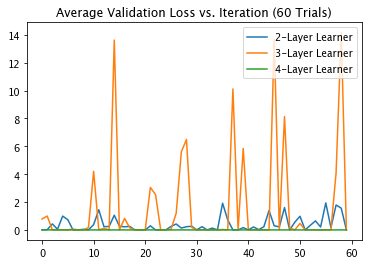

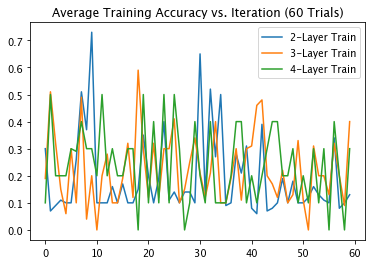

<function matplotlib.pyplot.show(*args, **kw)>

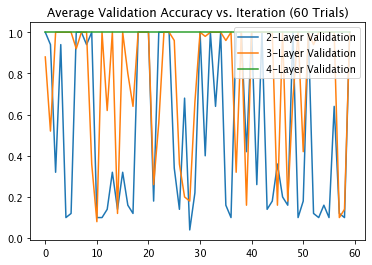

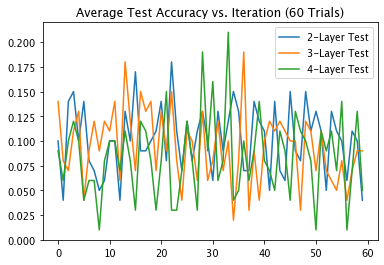

In [67]:
import matplotlib.pyplot as plt
%matplotlib inline

''' Compare Performances Averaged Across Trials '''
# Plot Loss
plt.figure()
plt.plot(np.arange(0, len(losses2), 1), losses2, '-', label="2-Layer Learner")
plt.plot(np.arange(0, len(losses3), 1), losses3, '-', label="3-Layer Learner")
plt.plot(np.arange(0, len(losses4), 1), losses4, '-', label="4-Layer Learner")
plt.legend(loc="upper right")
plt.title("Average Validation Loss vs. Iteration (60 Trials)")
plt.show

# Plot Accuracy
plt.figure()
plt.plot(np.arange(0, len(train2), 1), train2, '-', label="2-Layer Train")
plt.plot(np.arange(0, len(train3), 1), train3, '-', label="3-Layer Train")
plt.plot(np.arange(0, len(train4), 1), train4, '-', label="4-Layer Train")
plt.legend(loc="upper right")
plt.title("Average Training Accuracy vs. Iteration (60 Trials)")
plt.show()

plt.figure()
plt.plot(np.arange(0, len(valid2), 1), valid2, '-', label="2-Layer Validation")
plt.plot(np.arange(0, len(valid4), 1), valid3, '-', label="3-Layer Validation")
plt.plot(np.arange(0, len(valid4), 1), valid4, '-', label="4-Layer Validation")
plt.legend(loc="upper right")
plt.title("Average Validation Accuracy vs. Iteration (60 Trials)")
plt.show

plt.figure()
plt.plot(np.arange(0, len(test2), 1), test2, '-',label="2-Layer Test")
plt.plot(np.arange(0, len(test3), 1), test3, '-', label="3-Layer Test")
plt.plot(np.arange(0, len(test3), 1), test4, '-', label="4-Layer Test")
plt.legend(loc="upper right")
plt.title("Average Test Accuracy vs. Iteration (60 Trials)")
plt.show